# Chapter 17: Variational Quantum Linear Solver

Variational Quantum Linear Solver (VQLS) and parametric circuits.

---

**Prerequisites:**
- Python 3.8+
- Qiskit 2.1.2
- See `Chapter02_Software.ipynb` for installation instructions


In [1]:
# Setup and imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from qiskit_aer import Aer
from Chapter17_VQLS_functions import myVQLS

print('Setup complete!')

Setup complete!


## VQLS Examples

In [2]:


example = 1
if (example == 1):
	A = np.array([[1,0],[0,0.75]]) 
	b = np.array([0,1])
elif (example == 2):
	A = np.array([[2,-1],[-1,2]])
	b = np.array([1,1])/np.sqrt(2)
elif (example == 3):
	A = np.array([[1,0,0,-0.5],[0,1,0,0],[0,0,1,0],[-0.5,0,0,1]])
	b = np.array([1,0,0,0])
elif (example == 4):
	A = np.array([[1.5,0.5],[0.5,1.5]])
	b = np.array([1,0])
elif (example == 5):
	p = 2
	A = np.array([[5*(10**p),-1],[-1,5]])
	b = np.array([1,0])
elif (example == 6):
	N = 4
	values = [-np.ones(N-1),2*np.ones(N),-np.ones(N-1)]
	A = diags(values,[-1,0,1]).toarray()
	b = np.zeros(N)
	b[0] = 1

print("A:\n", A)
print("b:\n", b)

A:
 [[1.   0.  ]
 [0.   0.75]]
b:
 [0 1]


## VQLS Execution

Exact sol: [0. 1.]
------------------------------
Min Cost:  -0.0004177383234891252
Optimal theta:  [3.09338221]
VQLS  sol: [0.04472136 0.9989995 ]


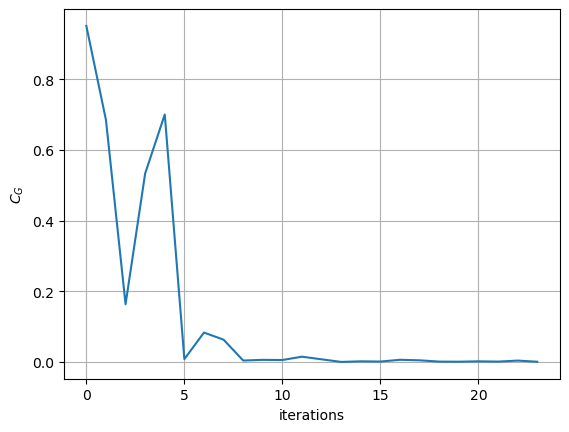

In [3]:
nShots = 1000
vqls = myVQLS(A, b,nShots)

vqls.solveuExact()
print('Exact sol:',vqls.uExact)
vqls.executeVQLS()
plt.plot(vqls.CostIterations)
plt.xlabel(r'iterations')
plt.ylabel(r'$C_G$')
plt.grid(True)
print("------------------------------")
print('Min Cost: ', vqls.minCG)
print('Optimal theta: ', vqls.thetaOptimal)
print('VQLS  sol:',vqls.uVQLS)